# Insurance Cost Prediction with Sci-kit Learn


## Libraries

In [6]:
# Regular Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Sci-kit Regression Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

# Sci-kit Regression Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Sci-kit Preprocessing
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# XGBoost
from xgboost import XGBRegressor

## Business Problem

In this project, we're going to create and tune a machine learning model for the usage of prediction of medical insurance costs.

We'll both use Sci-kit Learn library and TensorFlow, to compare which type of machine learning model (Sc-kit regression algorithms or artifical neural networks) will be best estimator for the target value.

Since we're facing with a regression problem, our main evaluation metric will simply be R-Square.

## Data

The data set is taken from Kaggle, **Medical Cost Personel Datasets**.

**Link:** https://www.kaggle.com/datasets/mirichoi0218/insurance

**Features:**
1. age: age of primary beneficiary
2. sex: insurance contractor gender, female, male
3. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
4. children: Number of children covered by health insurance / Number of dependents
5. smoker: Smoking
6. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest
7. charges: Individual medical costs billed by health insurance

In [8]:
# Import the dataset into notebook
data = pd.read_csv("insurance.csv")

# Create a copy of original dataset
df = data.copy()

In [5]:
# Observe the first 5 rows of the dataset for validation
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis

We can check out the summary information by using `info()` method.

We can see that there are 1338 observation in the dataset, and the data seems so clean since there are no missing values.

From `age` to `region`, the columns will be **features** for our model, while `charges` column will be our **target** value.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Let's examine the age column first.

In [5]:
df.age.describe().T

,age
count,1338.000000
mean,39.207025
std,14.049960
min,18.000000
25%,27.000000
50%,39.000000
75%,51.000000
max,64.000000


Let's create a function to use whenever we want to check distribution of a column.

In [7]:
def check_distribution(data: pd.DataFrame,
                       feature_name: str,
                       title: str,
                       xlabel: str,
                       ylabel: str,
                       bins: int = 50):

  # Plot the figure
  plt.figure(figsize = (8, 6))

  # Create the histogram
  sns.histplot(data[feature_name], bins = bins)

  # Customize the figure
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

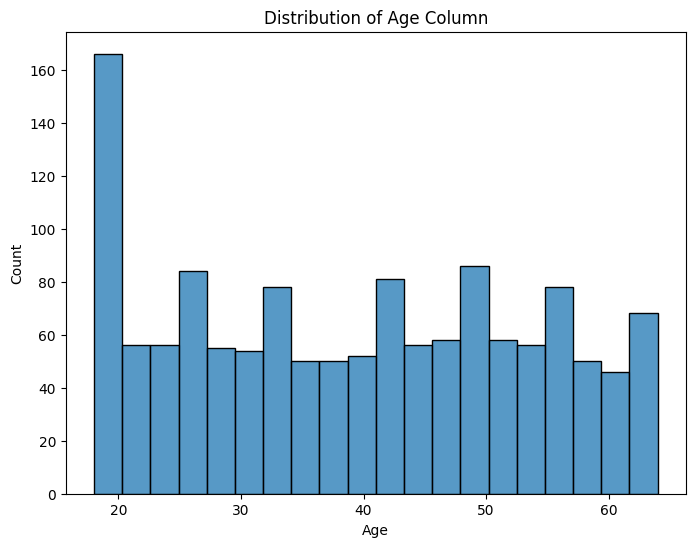

In [7]:
check_distribution(df, "age", "Distribution of Age Column", "Age", "Count", 20)

❓**What is the most frequent age value in the dataset?**


In [8]:
print(f"The most frequent observation in Age column is {df.age.value_counts().index.values[0]} with frequency {df.age.value_counts().iloc[0]}.")

The most frequent observation in Age column is 18 with frequency 69.


❓**Is there any outlier in age column?**

We already know that all age values are between normal values in the dataset, but we can also check it by plotting boxplot.

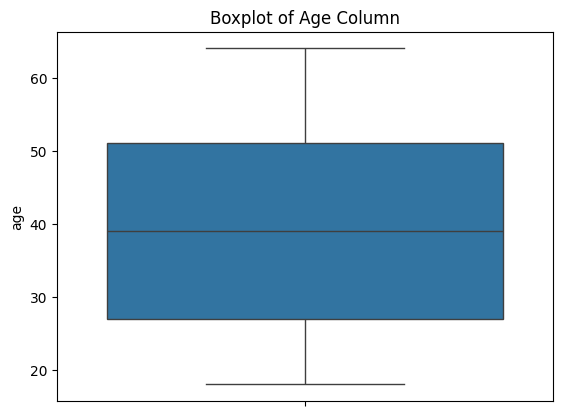

In [9]:
sns.boxplot(df.age)

plt.title("Boxplot of Age Column")
plt.show()

❓**Is there any relation between age and charges column?**

If look at the scatter plot, given below, we can see that there are three segment in the dataset.

1. First segment with the low insurance cost including most of the patients between 0-10,000.
2. Second segment is located between 10,000 and 30,000.
3. Third and the last segment can be observed between 30,000 and 50,000.

Common feature of these segments is, as age increases, insurance cost also increases.

We can say that, older people tend to have higher insurance cost according to dataset.

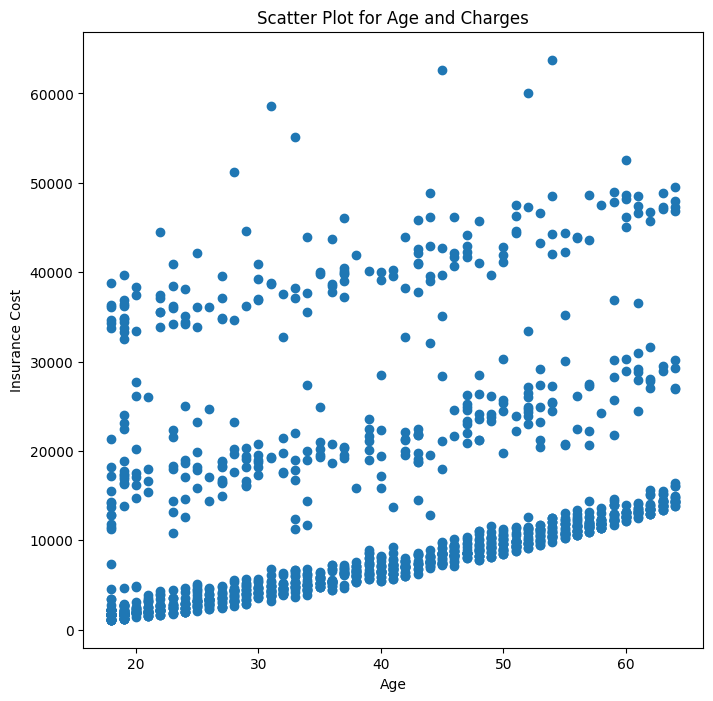

In [10]:
plt.figure(figsize = (8, 8))
plt.scatter(x = df["age"],
            y = df["charges"])

plt.title("Scatter Plot for Age and Charges")
plt.xlabel("Age")
plt.ylabel("Insurance Cost")
plt.show()

We can observe that, the mean insurance cost per age increases as age increases.

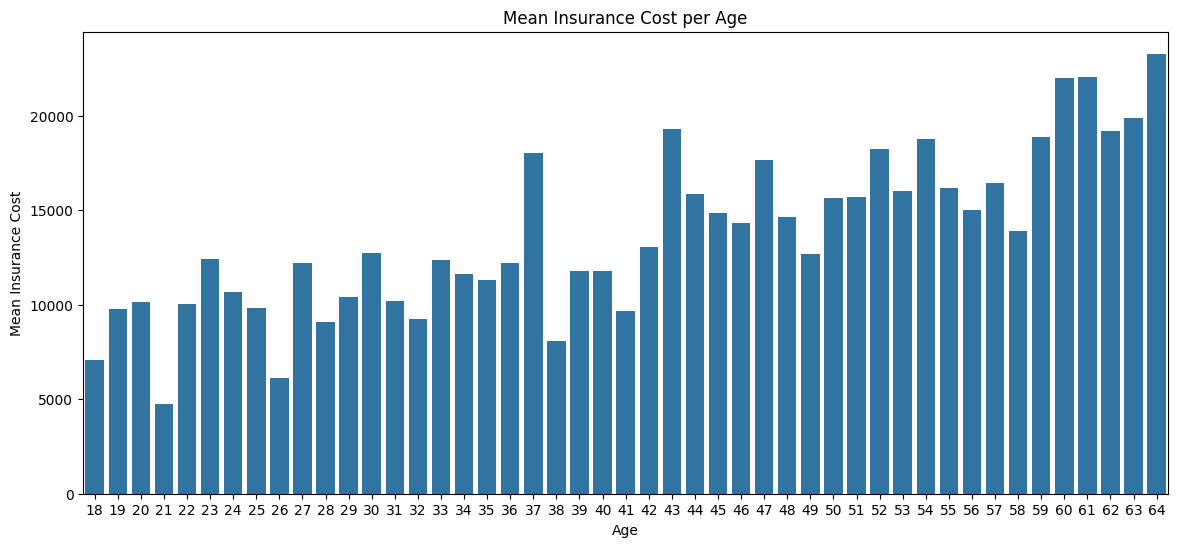

In [11]:
ages = df.groupby("age")["charges"].mean().sort_values(ascending = False).index.values
mean_cost_per_age = df.groupby("age")["charges"].mean().sort_values(ascending = False).values

plt.figure(figsize = (14, 6))
sns.barplot(x = ages, y = mean_cost_per_age)
plt.title("Mean Insurance Cost per Age")
plt.xlabel("Age")
plt.ylabel("Mean Insurance Cost")
plt.show()

In [12]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


❓**What are the percentages of males and females in the dataset?**

Males and females are almost 50-50 in the dataset, we are lucky to have a balanced dataset.

In [13]:
df["sex"].value_counts() / df["sex"].value_counts().sum() * 100

,count
sex,
male,50.523169
female,49.476831


❓**What are the mean insurance costs per sex?**

Mean insurance costs per sex are 12,569 for females and 13,956 for males.

In [14]:
df.groupby("sex")["charges"].mean()

,charges
sex,
female,12569.578844
male,13956.751178


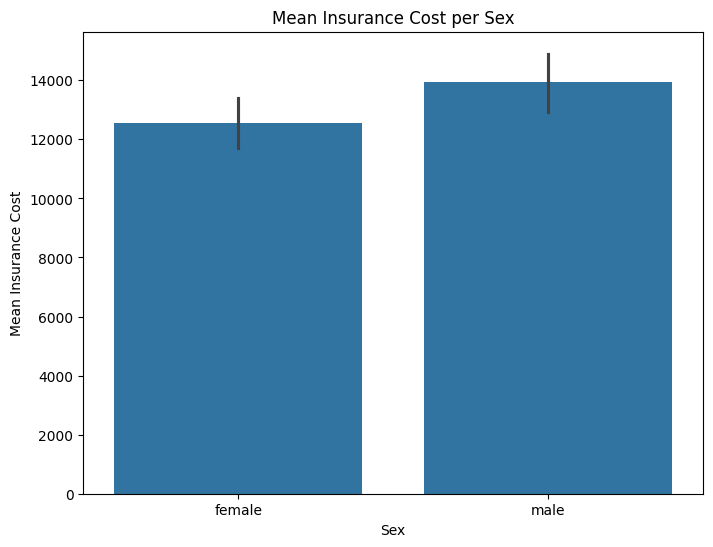

In [15]:
plt.figure(figsize = (8, 6))
sns.barplot(data = df, x = "sex", y = "charges")
plt.title("Mean Insurance Cost per Sex")
plt.xlabel("Sex")
plt.ylabel("Mean Insurance Cost")
plt.show()

In [16]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


❗ If we add smoker column as hue, we can clearly see that **mean insurance cost is higher for the people who smoke**.

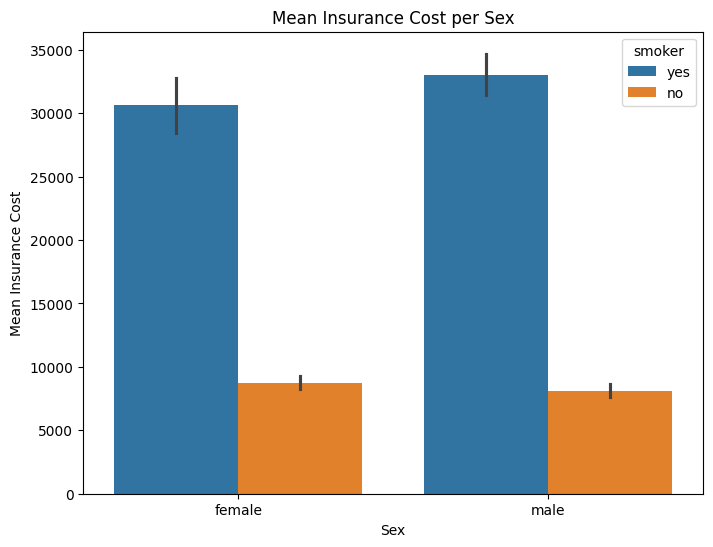

In [17]:
plt.figure(figsize = (8, 6))
sns.barplot(data = df, x = "sex", y = "charges", hue = "smoker")
plt.title("Mean Insurance Cost per Sex")
plt.xlabel("Sex")
plt.ylabel("Mean Insurance Cost")
plt.show()

❗ If we add region column as hue, we can clearly see that **mean insurance cost is higher for the people who live in shouteast region**.

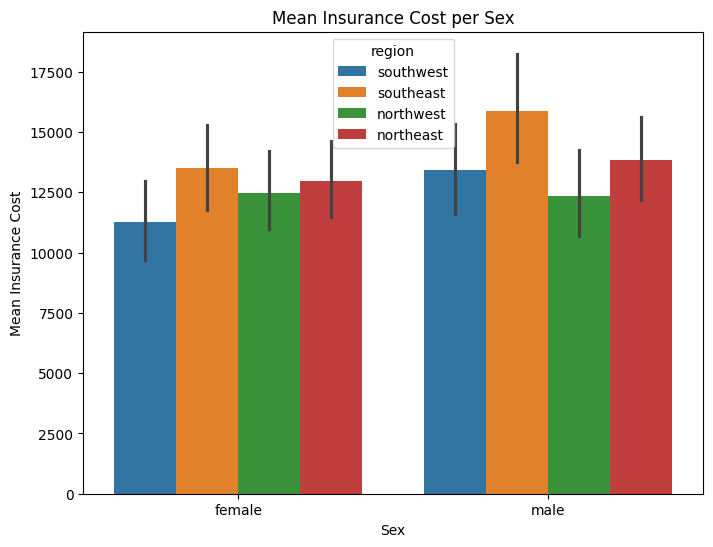

In [18]:
plt.figure(figsize = (8, 6))
sns.barplot(data = df, x = "sex", y = "charges", hue = "region")
plt.title("Mean Insurance Cost per Sex")
plt.xlabel("Sex")
plt.ylabel("Mean Insurance Cost")
plt.show()

❓**It also important to see the relation between BMI (Body Mass Index) and insurance costs.**

Mean insurance costs per sex are 12,569 for females and 13,956 for males

In [19]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


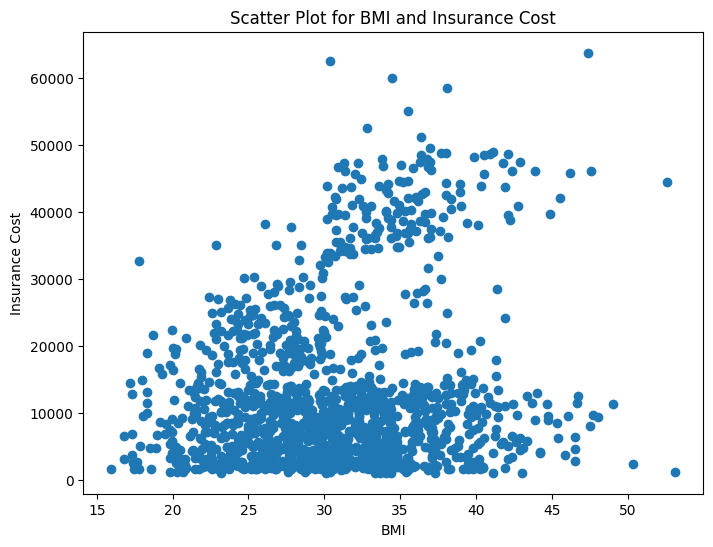

In [20]:
plt.figure(figsize = (8, 6))


plt.scatter(x = df.bmi, y = df.charges)
plt.title("Scatter Plot for BMI and Insurance Cost")
plt.xlabel("BMI")
plt.ylabel("Insurance Cost")
plt.show()

In [21]:
print(f"Maximum value of BMI column: {df.bmi.max()}, and the minimum value is {df.bmi.min()}")

Maximum value of BMI column: 53.13, and the minimum value is 15.96


According to website given below, if Body Mass Index

- under 18.5 – This is described as underweight.
- between 18.5 and 24.9 – This is described as the ‘healthy range’.
- between 25 and 29.9 – This is described as overweight
- between 30 and 39.9 – This is described as obesity
- 40 or over – This is described as severe obesity

If we look minimum and maximum values of BMI column, we can say that there are people who can be defined as *underweight* and *severe obesity*.

❓**I am curious about mean insurance costs per BMI category, we can create segmentations and check it.**

Look at the website:
https://www.nhsinform.scot/healthy-living/food-and-nutrition/healthy-eating-and-weight-management/body-mass-index-bmi/#:~:text=between%2018.5%20and%2024.9%20%E2%80%93%20This,is%20described%20as%20severe%20obesity

In [22]:
# Firstly, let's create a copy of the dataset.
df_bmi = df.copy()

# Create bins and labels for new BMI segment column
bmi_bins = [0, 18.5, 24.9, 29.9, 39.9, np.inf]
bmi_labels = ["underweight", "healthy", "overweight", "obesity", "severe obesity"]

# Create the segmentation into a new column
df_bmi["bmi_segment"] = pd.cut(x = df_bmi["bmi"],
                               bins = bmi_bins,
                               labels = bmi_labels)

df_bmi

,age,sex,bmi,children,smoker,region,charges,bmi_segment
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obesity
2,28,male,33.000,3,no,southeast,4449.46200,obesity
3,33,male,22.705,0,no,northwest,21984.47061,healthy
4,32,male,28.880,0,no,northwest,3866.85520,overweight
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,obesity
1334,18,female,31.920,0,no,northeast,2205.98080,obesity
1335,18,female,36.850,0,no,southeast,1629.83350,obesity
1336,21,female,25.800,0,no,southwest,2007.94500,overweight


We can say that, mean insurance cost increases as BMI value increase.

I expected that, also underweight segment would have higher mean insurance cost than other segments like severe obesity does.

It can clearly see that, according to dataset, being underweight is less dangerous than other segments.

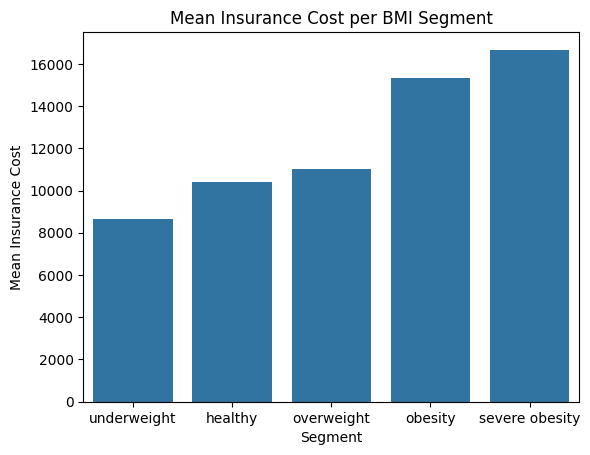

In [23]:
bmi_segments = df_bmi.groupby(by = "bmi_segment", observed = True)["charges"].mean().index.values
mean_insurance_per_segment = df_bmi.groupby(by = "bmi_segment", observed = True)["charges"].mean().values

plt.title("Mean Insurance Cost per BMI Segment")
sns.barplot(x = bmi_segments, y = mean_insurance_per_segment)
plt.xlabel("Segment")
plt.ylabel("Mean Insurance Cost")
plt.show()

❓**Is there any correlation between numerical features?**

We can observe the Pearson correlation values and visualize it by using heatmap. As we can see, highest correlation among features belongs to age-charges pair with 0.3 (correlation value stands between 0 and 1). This value is not high enough to take an action about.

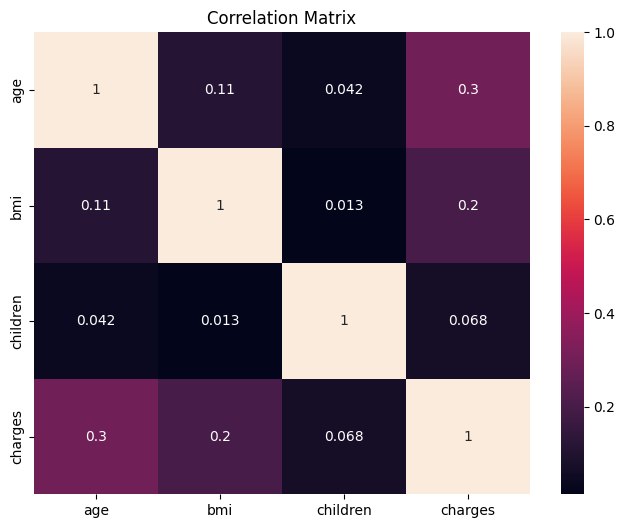

In [24]:
plt.figure(figsize = (8, 6))
sns.heatmap(df[["age", "bmi", "children", "charges"]].corr(), annot = True)
plt.title("Correlation Matrix")
plt.show()

❓**What are the frequencies of number of children?**

While most of the patients have no child, 43 patients have more than 3 children in the dataset. Let's also visualize it.

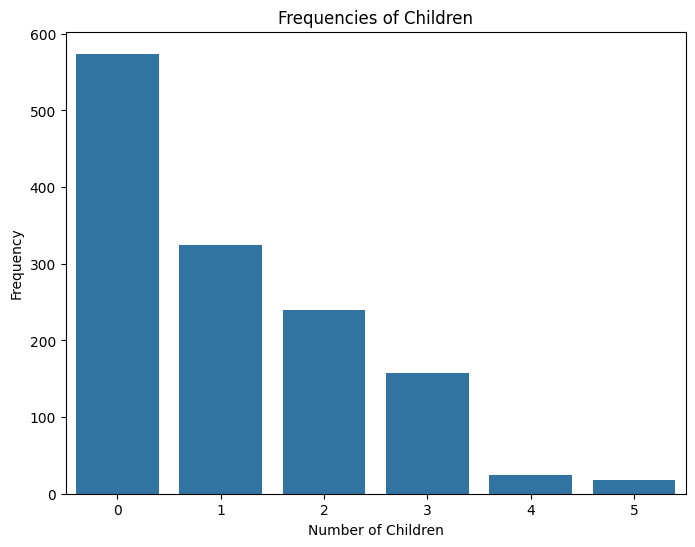

In [25]:
plt.figure(figsize = (8, 6))
sns.countplot(data = df, x = "children")

plt.title("Frequencies of Children")
plt.xlabel("Number of Children")
plt.ylabel("Frequency")
plt.show()

Let's examine our target value.

In [26]:
df.charges.describe().T

,charges
count,1338.000000
mean,13270.422265
std,12110.011237
min,1121.873900
25%,4740.287150
50%,9382.033000
75%,16639.912515
max,63770.428010


We can observe that our target value clearly right-skewed, it'll be better if we check about outliers.

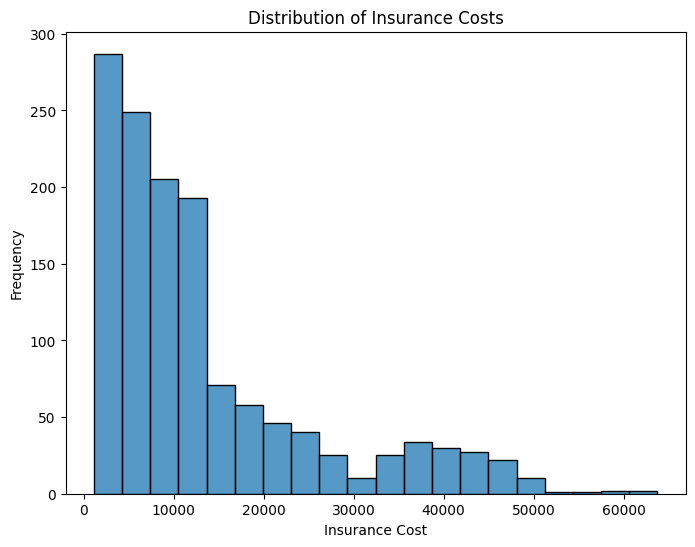

In [27]:
check_distribution(data = df,
                   feature_name = "charges",
                   title = "Distribution of Insurance Costs",
                   xlabel = "Insurance Cost",
                   ylabel = "Frequency",
                   bins = 20)

❗: It seems that there are many values which can be identified as outliers, according to interquartile ranges of the feature.



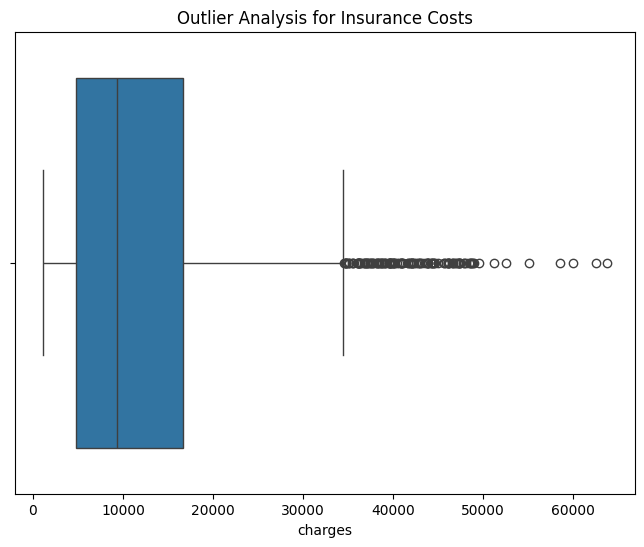

In [28]:
plt.figure(figsize = (8, 6))
sns.boxplot(data = df, x = "charges")
plt.title("Outlier Analysis for Insurance Costs")
plt.show()

Let's create a function for seperating outliers and data without outliers in `Data Preprocessing` section.

## Data Preprocessing

In [29]:
def outlier_analyser(data: pd.DataFrame, column: str):

  # Find the Q1 and Q3 values
  q1 = data[column].quantile(.25)
  q3 = data[column].quantile(.75)

  # Calculate the IQR
  iqr = q3-q1

  # Calculate upper and lower thresholds
  lower_threshold = q1 - 1.5*iqr
  upper_threshold = q3 + 1.5*iqr

  # Filter the data with outliers
  data_outlier = data[(data[column] < lower_threshold) | (data[column] > upper_threshold)]

  # Filter the data without outliers
  data_wout_outlier = data[~((data[column] < lower_threshold) | (data[column] > upper_threshold))]

  # Print the information
  print(f"Q1 value: {q1},\nQ3 value: {q3},\nIQR value: {iqr}")
  print(f"Upper threshold: {upper_threshold}")
  print(f"Lower threshold: {lower_threshold}")
  print(f"Total number of outliers in {column} is {len(data_outlier)}.")
  print(f"{len(data[data[column] < lower_threshold])} observations are lower than lower_threshold.")
  print(f"{len(data[data[column] > upper_threshold])} observations are upper than upper_threshold.")

  # Return datasets
  return (data_outlier, data_wout_outlier)

In [30]:
data_outlier, data_wout_outlier = outlier_analyser(data = df,
                                                   column = "charges")

Q1 value: 4740.28715,
Q3 value: 16639.912515,
IQR value: 11899.625365
Upper threshold: 34489.350562499996
Lower threshold: -13109.1508975
Total number of outliers in charges is 139.
0 observations are lower than lower_threshold.
139 observations are upper than upper_threshold.


In [31]:
data_outlier

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


In [32]:
data_wout_outlier

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


❗: **Outlier Analysis**

- According the Interquartile Range, there are 139 observations which can be defined as outliers. We can assume that, a person can have insurance charge more than 60,000, it is not unnormal. On the other hand, we have to consider generalization issue so we'll continue with the dataset without outliers.

**Important Note**: According to new boxplot, some values again seems like outliers since quartiles and IQR value calculated again on new data (the data created by dropping outliers from original one). This situation is absolutely normal, and since we're assuming these values can be normal, for preventing from more data loss, we'll continue with this data for machine learning.

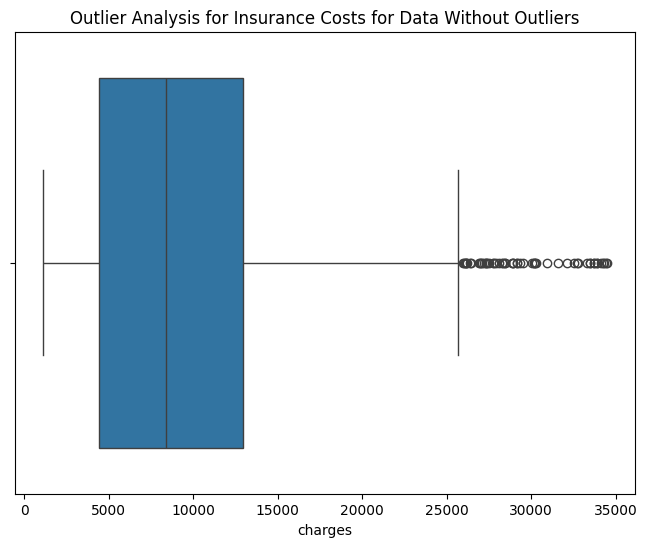

In [33]:
plt.figure(figsize = (8, 6))
sns.boxplot(data = data_wout_outlier, x = "charges")
plt.title("Outlier Analysis for Insurance Costs for Data Without Outliers")
plt.show()

In [34]:
# I'll rename the dataframe we're working on to df again.
df = data_wout_outlier.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1199 non-null   int64  
 1   sex       1199 non-null   object 
 2   bmi       1199 non-null   float64
 3   children  1199 non-null   int64  
 4   smoker    1199 non-null   object 
 5   region    1199 non-null   object 
 6   charges   1199 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 74.9+ KB


At this point, we have to determine which kind of scaler that we should use.

We're going to encode categorical columns with OneHotEncoder.

To make a decision between MinMaxScaler and StandardScaler, let's check the distributions of numerical columns.

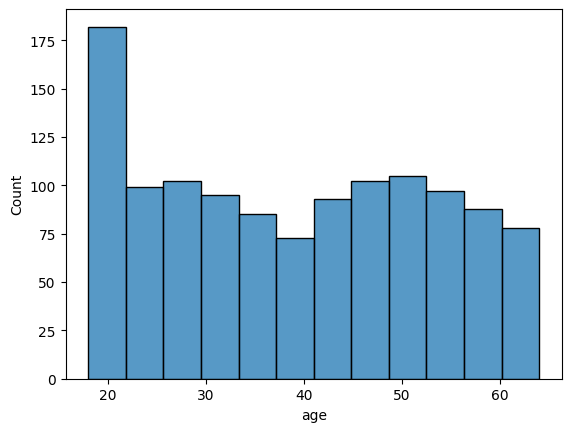

In [35]:
sns.histplot(df["age"]);

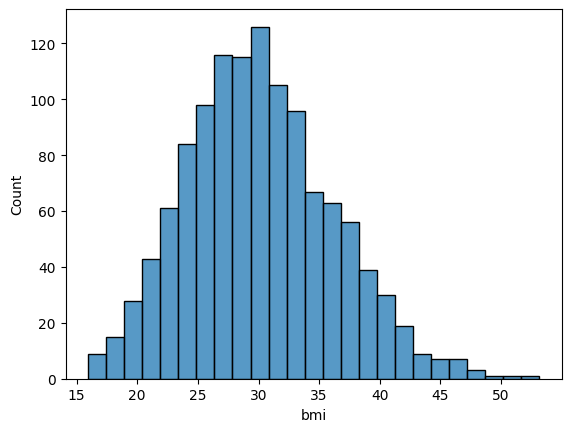

In [36]:
sns.histplot(df["bmi"]);

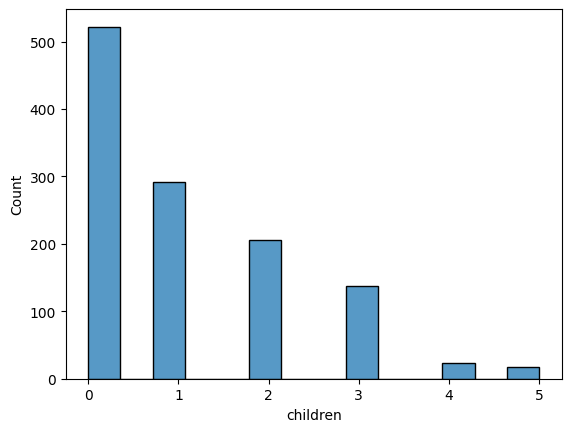

In [37]:
sns.histplot(df["children"]);

Our numerical columns are not highly skewed but cannot say distributed normally too.

Let's apply MinMaxScaler, we can still try other one as an experiment.

In [38]:
# One-Hot Encoding and Standardization

# Create a ColumnTransformer object
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]),
    (OneHotEncoder(drop = 'first', handle_unknown = "ignore"), ["smoker", "sex", "region"])
)

# Create feature sets and target column
X = df.drop("charges", axis = 1)
y = df.charges

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Apply column transformation to train set
ct.fit(X_train)

# Transform train and test set
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

## Model Selection

According to Sci-kit Learn Algorithm Cheat Sheet (https://scikit-learn.org/stable/machine_learning_map.html), we can roughly try to get results from the models:

- Lasso
- ElasticNet
- Ridge
- Ensemble Regressors (I'll simply try Random Forest Regressor)

And additionaly XGB Regressor from XGBoost.


In [51]:
def base_regressor(X_train,
                   y_train,
                   model_dict,
                   cv_scoring : str,
                   xgb: bool = False):

  # Create model dictionary in function
  models = model_dict

  # Create results DataFrame
  results_df = pd.DataFrame([],
                            index = list(models.keys()),
                            columns = ["Cross-Validation Score"])

  # Fit the model and make the predictions
  for name, model in models.items():
    # Instantiate the model
    model_ = model

    # Fit the model
    model_.fit(X_train, y_train)

    # Make prediction
    cv_scores = cross_val_score(estimator = model_, X = X_train, y = y_train, cv = 5, scoring = cv_scoring)
    cv_score = cv_scores.mean()

    # Add CV score into results_df and sort it
    results_df.loc[name] = cv_score

  # Need to create an instance for XGBRegressor.
  if xgb:
    xgb = XGBRegressor()
    cv_scores = cross_val_score(estimator = model_, X = X_train, y = y_train, cv = 5, scoring = cv_scoring)
    cv_score = cv_scores.mean()
    results_df.loc["xgb"] = cv_score

  results_df.sort_values(by = "Cross-Validation Score", ascending = False, inplace = True)
  # Return results dataframe
  return results_df


In [40]:
# Create model dictionary
models = {
    "rfr" : RandomForestRegressor(),
    "ridge" : Ridge(),
    "lasso" : Lasso(),
    "enet" : ElasticNet()
}

In [41]:
# Let's look at base CV scores
base_results = base_regressor(X_train = X_train_normal, y_train = y_train, model_dict = models, cv_scoring = "r2", xgb = True)
base_results

,Cross-Validation Score
ridge,0.604418
lasso,0.604386
rfr,0.596115
enet,0.162697
xgb,0.162697


In [42]:
# One-Hot Encoding and Standardization

# Create a ColumnTransformer object with StandardScaler instead of MinMaxScaler.
ct_sc = make_column_transformer(
    (StandardScaler(), ["age", "bmi", "children"]),
    (OneHotEncoder(drop = 'first', handle_unknown = "ignore"), ["smoker", "sex", "region"])
)

# Create feature sets and target column
X = df.drop("charges", axis = 1)
y = df.charges

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Apply column transformation to train set
ct_sc.fit(X_train)

# Transform train and test set
X_train_normal_sc = ct_sc.transform(X_train)
X_test_normal_sc = ct_sc.transform(X_test)


# Let's look at base CV scores
base_results_sc = base_regressor(X_train = X_train_normal_sc, y_train = y_train, model_dict = models, cv_scoring = "r2", xgb = True)
base_results_sc


,Cross-Validation Score
lasso,0.604379
ridge,0.60435
rfr,0.595505
enet,0.285787
xgb,0.285787


In [43]:
base_results

,Cross-Validation Score
ridge,0.604418
lasso,0.604386
rfr,0.596115
enet,0.162697
xgb,0.162697


As a result, we can see that, for regression based models and Random Forest Regressor MinMaxScaler slightly performed better than StandardScaler, but ElasticNet (combination of Ridge and Lasso) and XGBRegressor performed better (but still worst than other models) with StandardScaler.

We'll keep going with hyperparameter tuning of Ridge Regressor by using MinMaxScaler.

## Hyperparameter Optimization

Ridge, Lasso and Random Forest Regressor obtained close mean cross-validation scores but highest one is belongs to Ridge Regression.

I want to make an exhaustive hyper-parameter tuning with GridSearchCV.

In [44]:
# Set the random seed
np.random.seed(42)

# Create a parameter grid
param_grid = {
    "alpha" : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "solver" : ['svd', "cholesky", "saga"],
    "fit_intercept" : [True, False]
}

# Setup GridSearch
reg_gs = GridSearchCV(estimator = Ridge(),
                      param_grid = param_grid,
                      cv = 5,
                      verbose = 1)

# Fit the GridSearch
reg_gs.fit(X_train_normal, y_train)

# Find the best parameters
print(f"The best parameter values are: {reg_gs.best_params_}")
print(f"With a score of: {reg_gs.best_score_}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
The best parameter values are: {'alpha': 1, 'fit_intercept': True, 'solver': 'cholesky'}
With a score of: 0.604417558816421


In [45]:
# Set the Ridge again with best parameters
ridge_tuned = reg_gs.best_estimator_
ridge_tuned

Ridge(alpha=1, solver='cholesky')

In [46]:
# Fit the best model again
ridge_tuned.fit(X_train_normal, y_train)

# Check the model performance on test set
ridge_tuned.score(X_test_normal, y_test)

0.5579613036919454

## Experiment 1:
Let's setup the Experiment 1.

- No removing outliers.
- Scaling with MinMaxScaler.

In [47]:
df = data.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [48]:
# Create X and y set.
X = df.drop('charges', axis = 1)
y = df["charges"]

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [58]:
# Create column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]),
    (OneHotEncoder(handle_unknown = "ignore", drop = 'first'), ["sex", "smoker", "region"])
)

# Fit the transformer
ct.fit(X_train)

# Transform X_train and X_test
X_train_exp1 = ct.transform(X_train)
X_test_exp1 = ct.transform(X_test)

In [59]:
# Let's check the base scores
base_results_ex1 = base_regressor(X_train = X_train_exp1,
                                  y_train = y_train,
                                  model_dict = models,
                                  cv_scoring = "r2",
                                  xgb = True)

base_results_ex1

,Cross-Validation Score
rfr,0.823482
ridge,0.733235
lasso,0.73313
enet,0.289546
xgb,0.289546


✅: It looks like keeping data points which are considered as outliers effected the model very well. We'll see the test set performance.

Since our best results obtained by Random Forest Regressor, we can tune it.

In [61]:
# Set the random seed
np.random.seed(42)

# Create a parameter grid
rfr_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Setup GridSearch
rfr_gs = GridSearchCV(estimator = RandomForestRegressor(),
                      param_grid = rfr_param_grid,
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1)

# Fit the GridSearch
rfr_gs.fit(X_train_exp1, y_train)

# Find the best parameters
print(f"The best parameter values are: {rfr_gs.best_params_}")
print(f"With a score of: {rfr_gs.best_score_}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
The best parameter values are: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
With a score of: 0.8402766427461948


In [64]:
# Instantiate the best model
model_exp1 = rfr_gs.best_estimator_

# Fit the model
model_exp1.fit(X_train_exp1, y_train)

# Score the model
model_exp1.score(X_test_exp1, y_test)

0.8726347661295957